# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand, count
from pyspark.sql import functions as func
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType

In [3]:
from pyspark.ml.linalg import DenseVector, SparseVector, Vectors, VectorUDT
from pyspark.sql import functions as F
from pyspark.sql.types import *

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC
from pyspark.ml.feature import StandardScaler, MinMaxScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [5]:
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

In [6]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

Exception: Java gateway process exited before sending its port number

In [6]:
1+1

2

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
df = spark.read.json('mini_sparkify_event_data.json')

In [7]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [8]:
df.filter(df['userId']=='').count()

8346

In [9]:
df.filter(df['sessionId']=='').count()

0

In [10]:
df_cleaned = df.filter(df['userId']!='')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
df_cleaned.select("page").dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [12]:
df.select(['UserID']).collect()

[Row(UserID='30'),
 Row(UserID='9'),
 Row(UserID='30'),
 Row(UserID='9'),
 Row(UserID='30'),
 Row(UserID='9'),
 Row(UserID='9'),
 Row(UserID='30'),
 Row(UserID='30'),
 Row(UserID='30'),
 Row(UserID='9'),
 Row(UserID='9'),
 Row(UserID='30'),
 Row(UserID='9'),
 Row(UserID='9'),
 Row(UserID='30'),
 Row(UserID='9'),
 Row(UserID='74'),
 Row(UserID='30'),
 Row(UserID='9'),
 Row(UserID='74'),
 Row(UserID='30'),
 Row(UserID='54'),
 Row(UserID='9'),
 Row(UserID='74'),
 Row(UserID='30'),
 Row(UserID='54'),
 Row(UserID='9'),
 Row(UserID='74'),
 Row(UserID='30'),
 Row(UserID='54'),
 Row(UserID='9'),
 Row(UserID='30'),
 Row(UserID='74'),
 Row(UserID='54'),
 Row(UserID='54'),
 Row(UserID='30'),
 Row(UserID='9'),
 Row(UserID='30'),
 Row(UserID='54'),
 Row(UserID='74'),
 Row(UserID='9'),
 Row(UserID='74'),
 Row(UserID='54'),
 Row(UserID='54'),
 Row(UserID='30'),
 Row(UserID='9'),
 Row(UserID='9'),
 Row(UserID='74'),
 Row(UserID='30'),
 Row(UserID='9'),
 Row(UserID='9'),
 Row(UserID='9'),
 Row(UserID='

In [13]:
#mark user with churn event
flag_event = udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())
df_cleaned_churn = df_cleaned.withColumn('Churn_state',flag_event('page'))
userwindow = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df_cleaned_churn = df_cleaned_churn.withColumn('Churn',fmax('Churn_state').over(userwindow))

In [14]:
df_cleaned_churn.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churn_state=0, Churn=0)

In [15]:
aa = df_cleaned_churn.select(["userId", "Churn"]).dropDuplicates().groupby("Churn").agg(count("Churn")).toPandas()

In [16]:
list(aa['count(Churn)'])

[52, 173]

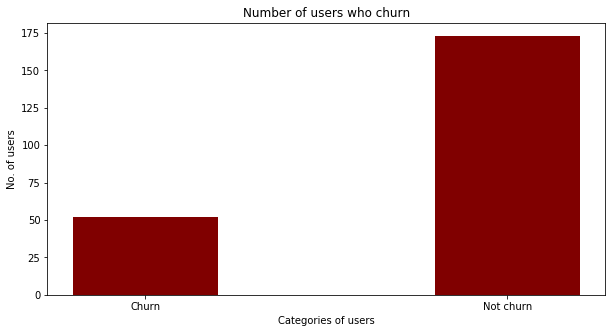

In [17]:
courses = ['Churn', 'Not churn']
values = list(aa['count(Churn)']) 
   
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(courses, values, color ='maroon',  
        width = 0.4) 
  
plt.xlabel("Categories of users") 
plt.ylabel("No. of users") 
plt.title("Number of users who churn") 
plt.show() 

In [18]:
bb = df_cleaned_churn.select(["userId", "Churn", "Artist"]).groupby("userId", "Churn").agg(count("Artist")).groupby("Churn").agg(avg("count(Artist)")).toPandas()

In [19]:
bb

,Churn,avg(count(Artist))
0,1,699.884615
1,0,1108.173410


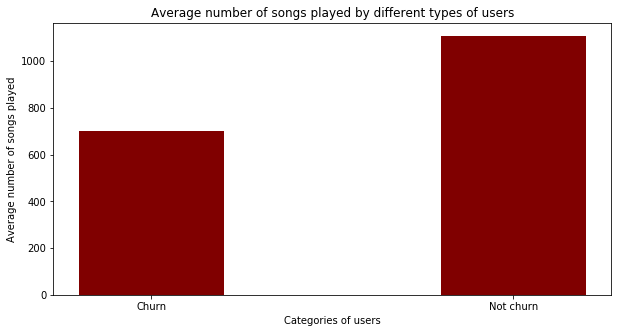

In [20]:
courses = ['Churn', 'Not churn']
values = list(bb['avg(count(Artist))']) 
   
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(courses, values, color ='maroon',  
        width = 0.4) 
  
plt.xlabel("Categories of users") 
plt.ylabel("Average number of songs played") 
plt.title("Average number of songs played by different types of users") 
plt.show() 

In [21]:
cc = df_cleaned_churn.select(["userId", "Churn", "Artist"]).dropDuplicates().groupby("userId", "Churn").agg(count("Artist")).groupby("Churn").agg(avg("count(Artist)")).toPandas()

In [22]:
cc

,Churn,avg(count(Artist))
0,1,518.692308
1,0,749.786127


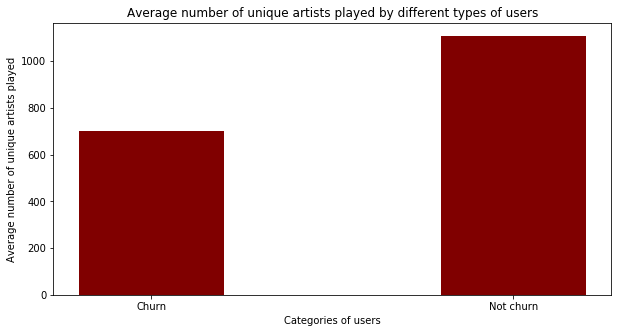

In [23]:
courses = ['Churn', 'Not churn']
values = list(bb['avg(count(Artist))']) 
   
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(courses, values, color ='maroon',  
        width = 0.4) 
  
plt.xlabel("Categories of users") 
plt.ylabel("Average number of unique artists played") 
plt.title("Average number of unique artists played by different types of users") 
plt.show() 

In [24]:
dd = df_cleaned_churn.select(["userId", "Churn", "song"]).dropDuplicates().groupby("userId", "Churn").agg(count("song")).groupby("Churn").agg(avg("count(song)")).toPandas()

In [25]:
dd

,Churn,avg(count(song))
0,1,638.365385
1,0,975.768786


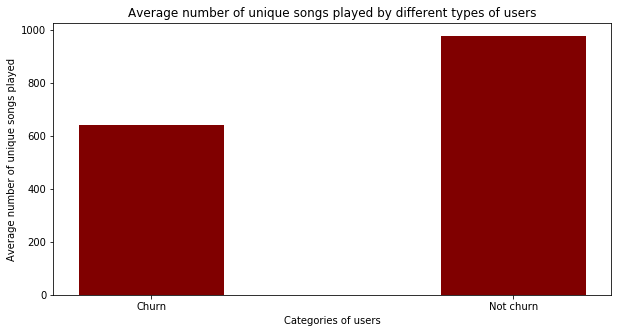

In [26]:
courses = ['Churn', 'Not churn']
values = list(dd['avg(count(song))']) 
   
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(courses, values, color ='maroon',  
        width = 0.4) 
  
plt.xlabel("Categories of users") 
plt.ylabel("Average number of unique songs played") 
plt.title("Average number of unique songs played by different types of users") 
plt.show()

In [27]:
df_cleaned_churn.select(["userId", "Churn", "auth"]).groupby("userId", "Churn", "auth").agg(count("auth")).groupby("Churn", "auth").agg(avg("count(auth)")).collect()

[Row(Churn=1, auth='Cancelled', avg(count(auth))=1.0),
 Row(Churn=0, auth='Logged In', avg(count(auth))=1348.4971098265896),
 Row(Churn=1, auth='Logged In', avg(count(auth))=861.7692307692307)]

In [28]:
df_cleaned_churn.select(["userId", "auth", "page"]).where(df.page == "Cancellation Confirmation").collect()

[Row(userId='18', auth='Cancelled', page='Cancellation Confirmation'),
 Row(userId='32', auth='Cancelled', page='Cancellation Confirmation'),
 Row(userId='125', auth='Cancelled', page='Cancellation Confirmation'),
 Row(userId='105', auth='Cancelled', page='Cancellation Confirmation'),
 Row(userId='17', auth='Cancelled', page='Cancellation Confirmation'),
 Row(userId='143', auth='Cancelled', page='Cancellation Confirmation'),
 Row(userId='101', auth='Cancelled', page='Cancellation Confirmation'),
 Row(userId='129', auth='Cancelled', page='Cancellation Confirmation'),
 Row(userId='121', auth='Cancelled', page='Cancellation Confirmation'),
 Row(userId='51', auth='Cancelled', page='Cancellation Confirmation'),
 Row(userId='87', auth='Cancelled', page='Cancellation Confirmation'),
 Row(userId='122', auth='Cancelled', page='Cancellation Confirmation'),
 Row(userId='12', auth='Cancelled', page='Cancellation Confirmation'),
 Row(userId='58', auth='Cancelled', page='Cancellation Confirmation'),

In [29]:
ee = df_cleaned_churn.select(["userId", "Churn", "gender"]).dropDuplicates().groupby("Churn", "gender").agg(count("userId")).toPandas()

In [30]:
ee

,Churn,gender,count(userId)
0,1,F,20
1,0,M,89
2,1,M,32
3,0,F,84


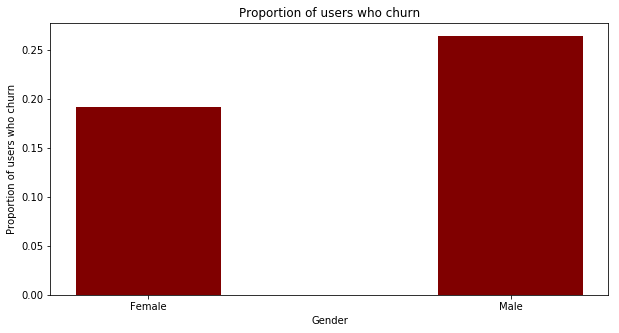

In [31]:
courses = ['Male', 'Female']
values = [32/(89+32), 20/(20+84)]
   
fig = plt.figure(figsize = (10, 5))
  
# creating the bar plot 
plt.bar(courses, values, color ='maroon',  
        width = 0.4)
  
plt.xlabel("Gender") 
plt.ylabel("Proportion of users who churn") 
plt.title("Proportion of users who churn") 
plt.show()

In [32]:
df_cleaned_churn.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churn_state=0, Churn=0)

In [33]:
flag_Thumbs_Up = udf(lambda x : 1 if x=='Thumbs Up' else 0, IntegerType())
df_cleaned_churn = df_cleaned_churn.withColumn('Thumbs_up',flag_Thumbs_Up('page'))

In [34]:
ff = df_cleaned_churn.select(["userId", "Churn", "Thumbs_up"]).groupby("userId", "Churn").sum("Thumbs_up").groupby("Churn").agg(avg("sum(Thumbs_up)")).toPandas()

In [35]:
ff

,Churn,avg(sum(Thumbs_up))
0,1,35.750000
1,0,61.803468


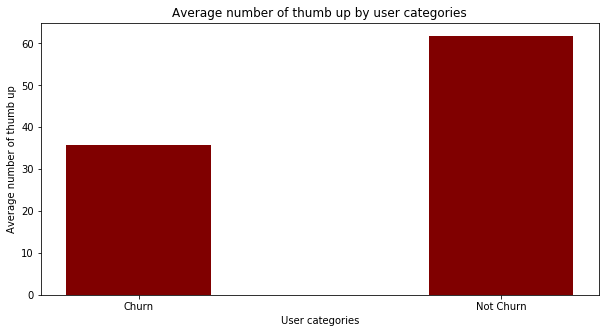

In [36]:
courses = ['Churn', 'Not Churn']
values = list(ff['avg(sum(Thumbs_up))'])
   
fig = plt.figure(figsize = (10, 5))
  
# creating the bar plot 
plt.bar(courses, values, color ='maroon',  
        width = 0.4)
  
plt.xlabel("User categories") 
plt.ylabel("Average number of thumb up") 
plt.title("Average number of thumb up by user categories") 
plt.show()

In [37]:
flag_Thumbs_Down = udf(lambda x : 1 if x=='Thumbs Down' else 0, IntegerType())
df_cleaned_churn = df_cleaned_churn.withColumn('Thumbs_down',flag_Thumbs_Down('page'))
ee = df_cleaned_churn.select(["userId", "Churn", "Thumbs_down"]).groupby("userId", "Churn").sum("Thumbs_down").groupby("Churn").agg(avg("sum(Thumbs_down)")).toPandas()

In [38]:
ee

,Churn,avg(sum(Thumbs_down))
0,1,9.538462
1,0,11.849711


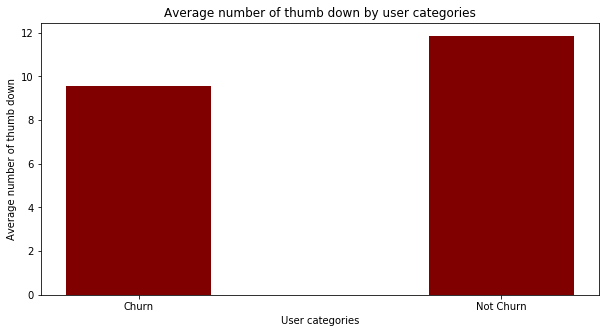

In [39]:
courses = ['Churn', 'Not Churn']
values = list(ee['avg(sum(Thumbs_down))'])
   
fig = plt.figure(figsize = (10, 5))
  
# creating the bar plot 
plt.bar(courses, values, color ='maroon',  
        width = 0.4)
  
plt.xlabel("User categories") 
plt.ylabel("Average number of thumb down") 
plt.title("Average number of thumb down by user categories") 
plt.show()

In [40]:
flag_NextSong = udf(lambda x : 1 if x=='NextSong' else 0, IntegerType())
df_cleaned_churn = df_cleaned_churn.withColumn('NextSong',flag_NextSong('page'))
gg = df_cleaned_churn.select(["userId", "Churn", "NextSong"]).groupby("userId", "Churn").sum("NextSong").groupby("Churn").agg(avg("sum(NextSong)")).toPandas()

In [41]:
gg

,Churn,avg(sum(NextSong))
0,1,699.884615
1,0,1108.173410


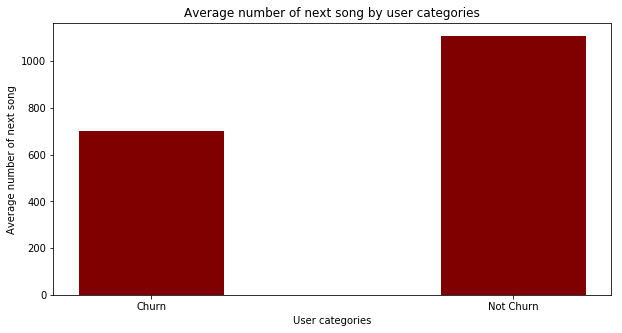

In [42]:
courses = ['Churn', 'Not Churn']
values = list(gg['avg(sum(NextSong))'])
   
fig = plt.figure(figsize = (10, 5))
  
# creating the bar plot 
plt.bar(courses, values, color ='maroon',  
        width = 0.4)
  
plt.xlabel("User categories") 
plt.ylabel("Average number of next song") 
plt.title("Average number of next song by user categories") 
plt.show()

In [43]:
flag_Add_Friend = udf(lambda x : 1 if x=='Add Friend' else 0, IntegerType())
df_cleaned_churn = df_cleaned_churn.withColumn('Add_Friend',flag_Add_Friend('page'))
hh = df_cleaned_churn.select(["userId", "Churn", "Add_Friend"]).groupby("userId", "Churn").sum("Add_Friend").groupby("Churn").agg(avg("sum(Add_Friend)")).toPandas()

In [44]:
hh

,Churn,avg(sum(Add_Friend))
0,1,12.230769
1,0,21.046243


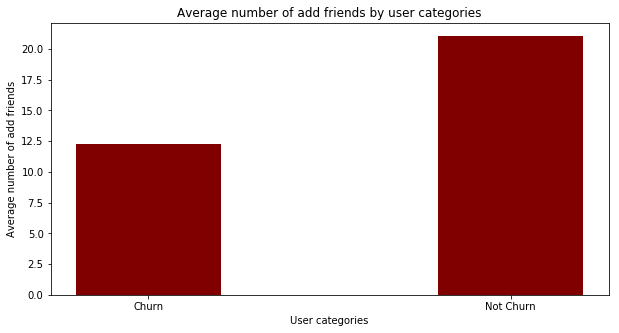

In [45]:
courses = ['Churn', 'Not Churn']
values = list(hh['avg(sum(Add_Friend))'])
   
fig = plt.figure(figsize = (10, 5))
  
# creating the bar plot 
plt.bar(courses, values, color ='maroon',  
        width = 0.4)
  
plt.xlabel("User categories") 
plt.ylabel("Average number of add friends") 
plt.title("Average number of add friends by user categories") 
plt.show()

In [46]:
flag_Add_to_Playlist = udf(lambda x : 1 if x=='Add to Playlist' else 0, IntegerType())
df_cleaned_churn = df_cleaned_churn.withColumn('Add_to_Playlist',flag_Add_to_Playlist('page'))
gg = df_cleaned_churn.select(["userId", "Churn", "Add_to_Playlist"]).groupby("userId", "Churn").sum("Add_to_Playlist").groupby("Churn").agg(avg("sum(Add_to_Playlist)")).toPandas()

In [47]:
gg

,Churn,avg(sum(Add_to_Playlist))
0,1,19.961538
1,0,31.722543


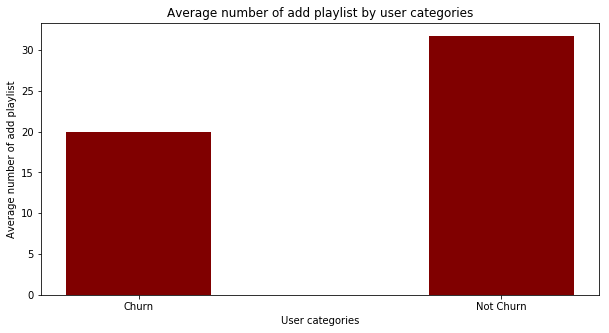

In [48]:
courses = ['Churn', 'Not Churn']
values = list(gg['avg(sum(Add_to_Playlist))'])
   
fig = plt.figure(figsize = (10, 5))
  
# creating the bar plot 
plt.bar(courses, values, color ='maroon',  
        width = 0.4)
  
plt.xlabel("User categories") 
plt.ylabel("Average number of add playlist") 
plt.title("Average number of add playlist by user categories") 
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [7]:
def preprocessing_and_feature_engineering():
    df_cleaned = df.filter(df['userId']!='')
    flag_event = udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())
    df_cleaned_churn = df_cleaned.withColumn('Churn_state',flag_event('page'))
    userwindow = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
    df_cleaned_churn = df_cleaned_churn.withColumn('Churn',fmax('Churn_state').over(userwindow))
    num_track = df_cleaned_churn.select(["userId", "Artist"]).groupby("userId").agg(count("Artist"))
    num_unique_artist = df_cleaned_churn.select(["userId", "Artist"]).dropDuplicates().groupby("userId").agg(count("Artist"))
    num_unique_artist = num_unique_artist.select(col("userId").alias("userId"), col("count(Artist)").alias("count(Artist2)"))
    num_unique_song = df_cleaned_churn.select(["userId", "song"]).dropDuplicates().groupby("userId").agg(count("song"))
    flag_Male = udf(lambda x : 1 if x=='M' else 0, IntegerType())
    df_cleaned_churn = df_cleaned_churn.withColumn('gender_M',flag_Male('gender'))
    flag_Thumbs_Up = udf(lambda x : 1 if x=='Thumbs Up' else 0, IntegerType())
    df_cleaned_churn = df_cleaned_churn.withColumn('Thumbs_up',flag_Thumbs_Up('page'))
    flag_Thumbs_Down = udf(lambda x : 1 if x=='Thumbs Down' else 0, IntegerType())
    df_cleaned_churn = df_cleaned_churn.withColumn('Thumbs_down',flag_Thumbs_Down('page'))
    flag_NextSong = udf(lambda x : 1 if x=='NextSong' else 0, IntegerType())
    df_cleaned_churn = df_cleaned_churn.withColumn('NextSong',flag_NextSong('page'))
    flag_Add_Friend = udf(lambda x : 1 if x=='Add Friend' else 0, IntegerType())
    df_cleaned_churn = df_cleaned_churn.withColumn('Add_Friend',flag_Add_Friend('page'))
    flag_Add_to_Playlist = udf(lambda x : 1 if x=='Add to Playlist' else 0, IntegerType())
    df_cleaned_churn = df_cleaned_churn.withColumn('Add_to_Playlist',flag_Add_to_Playlist('page'))
    male = df_cleaned_churn.select(["userId", "gender_M"])
    thumbs_up = df_cleaned_churn.select(["userId", "Thumbs_up"])
    thumbs_down = df_cleaned_churn.select(["userId", "Thumbs_down"])
    nextsong = df_cleaned_churn.select(["userId", 'NextSong'])
    add_friend = df_cleaned_churn.select(["userId", 'Add_Friend'])
    add_to_playlist = df_cleaned_churn.select(["userId", 'Add_to_Playlist'])
    churn = df_cleaned_churn.select(['userId', 'churn'])
    combined = churn.join(num_track, ["UserId"]).join(num_unique_artist, ["UserId"]).join(num_unique_song, ["UserId"]).join(male, ["UserId"]).join(thumbs_up, ["UserId"]).join(thumbs_down, ["UserId"]).join(nextsong, ["UserId"]).join(add_friend, ["UserId"]).join(add_to_playlist, ["UserId"])
    return combined

In [8]:
combined_data = preprocessing_and_feature_engineering()

In [9]:
combined_data.head()

Row(userId='100010', churn=0, count(Artist)=275, count(Artist2)=252, count(song)=269, gender_M=0, Thumbs_up=0, Thumbs_down=0, NextSong=1, Add_Friend=0, Add_to_Playlist=0)

In [ ]:
assembler = VectorAssembler(inputCols=["count(Artist)", "count(Artist2)", "count(song)", "Thumbs_up", "Thumbs_down", "NextSong", "Add_Friend", "Add_to_Playlist"], outputCol="features_")
combined_data = assembler.transform(combined_data)

In [10]:
toDense = lambda v: Vectors.dense(v.toArray())
toDenseUdf = F.udf(toDense, VectorUDT())

In [11]:
combined_data = combined_data.withColumn('features_', toDenseUdf('features_'))

In [12]:
combined_data.head()

Row(userId='100010', churn=0, count(Artist)=275, count(Artist2)=252, count(song)=269, gender_M=0, Thumbs_up=0, Thumbs_down=0, NextSong=1, Add_Friend=0, Add_to_Playlist=0, features_=DenseVector([275.0, 252.0, 269.0, 0.0, 0.0, 1.0, 0.0, 0.0]))

In [ ]:
scaler2 = StandardScaler(inputCol="features_", outputCol="features", withMean=False, withStd=False)

In [ ]:
scalerModel = scaler2.fit(combined_data)

In [ ]:
combined_data = scalerModel.transform(combined_data)

In [55]:
scaler2 = StandardScaler(inputCol="features", outputCol="ScaledFeatures")

In [56]:
scalerModel = scaler2.fit(combined_data)

KeyboardInterrupt: 

In [ ]:
combined_data.head()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.